In [1]:
from utils_copy import load_mnist
from mnist import MNIST
#from classifier import svm_classifier
import cv2
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import scipy.cluster.vq as vq
import numpy as np
import pickle
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
from classifier import svm_classifier
from collections import Counter
from matplotlib import pyplot as plt
import itertools
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [3]:
def build_spatial_pyramid(image, descriptor, level):
    """
    Rebuild the descriptors according to the level of pyramid
    """
    assert 0 <= level <= 2, "Level Error"
    step_size = 4
    #from utils import DSIFT_STEP_SIZE as s
    #assert s == step_size, "step_size must equal to DSIFT_STEP_SIZE\
                            #in utils.extract_DenseSift_descriptors()"
    h = int(image.shape[0] / step_size)
    w = int(image.shape[1] / step_size)
    idx_crop = np.array(range(len(descriptor))).reshape(h,w)
    size = idx_crop.itemsize
    height, width = idx_crop.shape
    bh, bw = 2**(3-level), 2**(3-level)
    shape = (int(height/bh), int(width/bw), bh, bw)
    strides = size * np.array([width*bh, bw, width, 1])
    crops = np.lib.stride_tricks.as_strided(
            idx_crop, shape=shape, strides=strides)
    des_idxs = [col_block.flatten().tolist() for row_block in crops
                for col_block in row_block]
    pyramid = []
    for idxs in des_idxs:
        pyramid.append(np.asarray([descriptor[idx] for idx in idxs]))
    return pyramid

def spatial_pyramid_matching(image, descriptor, codebook, level):
    pyramid = []
    if level == 0:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        code = [input_vector_encoder(crop, codebook) for crop in pyramid]
        return np.asarray(code).flatten()
    if level == 1:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        pyramid += build_spatial_pyramid(image, descriptor, level=1)
        code = [input_vector_encoder(crop, codebook) for crop in pyramid]
        code_level_0 = 0.5 * np.asarray(code[0]).flatten()
        code_level_1 = 0.5 * np.asarray(code[1:]).flatten()
        return np.concatenate((code_level_0, code_level_1))
    if level == 2:
        pyramid += build_spatial_pyramid(image, descriptor, level=0)
        pyramid += build_spatial_pyramid(image, descriptor, level=1)
        pyramid += build_spatial_pyramid(image, descriptor, level=2)
        code = [input_vector_encoder(crop, codebook) for crop in pyramid]
        code_level_0 = 0.25 * np.asarray(code[0]).flatten()
        code_level_1 = 0.25 * np.asarray(code[1:5]).flatten()
        code_level_2 = 0.5 * np.asarray(code[5:]).flatten()
        return np.concatenate((code_level_0, code_level_1, code_level_2))


def extract_DenseSift_descriptors(img):

    sift = cv2.xfeatures2d.SIFT_create()
    disft_step_size = DSIFT_STEP_SIZE
    keypoints = [cv2.KeyPoint(x, y, disft_step_size)
            for y in range(0, img.shape[0], disft_step_size)
                for x in range(0, img.shape[1], disft_step_size)]

    keypoints, descriptors = sift.compute(img, keypoints)

    #keypoints, descriptors = sift.detectAndCompute(gray, None)
    return [keypoints, descriptors]

def build_codebook(X, voc_size):
    """
    Inupt a list of feature descriptors
    voc_size is the "K" in K-means, k is also called vocabulary size
    Return the codebook/dictionary
    """
    features = np.vstack((descriptor for descriptor in X))
    kmeans = KMeans(n_clusters=voc_size, n_jobs=-2)
    kmeans.fit(features)
    codebook = kmeans.cluster_centers_.squeeze()
    return codebook

def input_vector_encoder(feature, codebook):
    """
    Input all the local feature of the image
    Pooling (encoding) by codebook and return
    """
    code, _ = vq.vq(feature, codebook)
    word_hist, bin_edges = np.histogram(code, bins=range(codebook.shape[0] + 1), normed=True)
    return word_hist

In [4]:
# choosing samples
mndata = MNIST('./data')

x_train, y_train  = mndata.load_training()
x_test, y_test = mndata.load_testing()


print(Counter(y_train))
print(Counter(y_test))

train_rand = np.random.randint(60000, size=10000)
temp = []
temp_y = []
for num in train_rand:
    temp.append(x_train[num])
    temp_y.append(y_train[num])
    
x_train = temp
y_train = temp_y

test_rand = np.random.randint(10000, size=10000)
temp = []
temp_y = []
for num in test_rand:
    temp.append(x_test[num])
    temp_y.append(y_test[num])

x_test = temp
y_test = temp_y 

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})
Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [5]:
VOC_SIZE = 100
PYRAMID_LEVEL = 2

DSIFT_STEP_SIZE = 4
# DSIFT_STEP_SIZE is related to the function
# extract_DenseSift_descriptors in utils.py
# and build_spatial_pyramid in spm.py


temp = []
temp_y = []
for i,image in enumerate(x_train):
        image = x_train[i]
        temp.append(np.array(image).reshape([28,28]).astype('uint8'))
        temp_y.append(y_train[i])
x_train = temp
y_train = temp_y

temp = []
temp_y = []

for i,image in enumerate(x_test):
        image = x_test[i]
        temp.append(np.array(image).reshape([28,28]).astype('uint8'))
        temp_y.append(y_test[i])
x_test = temp
y_test = temp_y       
#x_train, y_train = load_data(dataset='train')
#x_test, y_test = load_data(dataset='test')

print("Dense SIFT feature extraction")
x_train_feature = [extract_DenseSift_descriptors(img) for img in x_train]
x_test_feature = [extract_DenseSift_descriptors(img) for img in x_test]
x_train_kp, x_train_des = zip(*x_train_feature)
x_test_kp, x_test_des = zip(*x_test_feature)

print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))
print("Codebook Size: {:d}".format(VOC_SIZE))
print("Pyramid level: {:d}".format(PYRAMID_LEVEL))
print("Building the codebook, it will take some time")
codebook = build_codebook(x_train_des, VOC_SIZE)

#import pickle
#with open('./spm_lv1_codebook.pkl','wb') as f:
#    pickle.dump(codebook, f)

Dense SIFT feature extraction
Train/Test split: 10000/10000
Codebook Size: 100
Pyramid level: 2
Building the codebook, it will take some time


In [6]:
print("Spatial Pyramid Matching encoding")

x_train = [spatial_pyramid_matching(x_train[i],
                                        x_train_des[i],
                                        codebook,
                                        level=PYRAMID_LEVEL)
                                        for i in range(len(x_train))]

x_test = [spatial_pyramid_matching(x_test[i],
                                       x_test_des[i],
                                       codebook,
                                       level=PYRAMID_LEVEL) for i in range(len(x_test))]

x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

#svm_classifier(x_train, y_train, x_test, y_test)

Spatial Pyramid Matching encoding


In [7]:
svm_classifier(x_train, y_train, x_test, y_test)

Tuning hyper-parameters

Best parameters set found on development set:

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Grid scores on development set:

0.114 (+/-0.000) for {'C': 0.001, 'gamma': 0.001}
0.114 (+/-0.000) for {'C': 0.001, 'gamma': 0.01}
0.114 (+/-0.000) for {'C': 0.001, 'gamma': 0.1}
0.114 (+/-0.000) for {'C': 0.001, 'gamma': 1.0}
0.114 (+/-0.000) for {'C': 0.001, 'gamma': 10.0}
0.114 (+/-0.000) for {'C': 0.001, 'gamma': 100.0}
0.114 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.114 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.114 (+/-0.001) for {'C': 0.01, 'gamma': 0.1}
0.755 (+/-0.016) for {'C': 0.01, 'gamma': 1.0}
0.294 (+/-0.020) for {'C': 0.01, 'gamma': 10.0}
0.114 (+/-0.000) for {'C': 0.01, 'gamma': 100.0}
0.114 (+/-0.000) for {'C': 0.1, 'gamma': 0.001}
0.116 (+/-0.002) for {'C': 0.1, 'gamma': 

In [9]:
clf = svm.SVC(C = 100, gamma =1)
clf.fit(x_train, y_train)
z = clf.predict(x_test)
print(accuracy_score(z,y_test))

0.912


In [10]:
conf = confusion_matrix(z,y_test)

Normalized confusion matrix
[[9.42028986e-01 0.00000000e+00 5.79710145e-03 0.00000000e+00
  9.66183575e-04 6.76328502e-03 1.15942029e-02 3.86473430e-03
  1.83574879e-02 1.06280193e-02]
 [8.97666068e-04 9.81149013e-01 8.97666068e-04 0.00000000e+00
  1.79533214e-03 8.97666068e-04 2.69299820e-03 0.00000000e+00
  6.28366248e-03 5.38599641e-03]
 [3.80589914e-03 2.85442436e-03 9.17221694e-01 3.13986679e-02
  4.75737393e-03 7.61179829e-03 1.90294957e-03 1.80780209e-02
  1.04662226e-02 1.90294957e-03]
 [0.00000000e+00 9.83284169e-04 2.16322517e-02 8.45624385e-01
  0.00000000e+00 5.30973451e-02 0.00000000e+00 2.45821042e-02
  3.53982301e-02 1.86823992e-02]
 [3.07377049e-03 1.02459016e-03 1.02459016e-03 0.00000000e+00
  9.26229508e-01 2.04918033e-03 1.53688525e-02 0.00000000e+00
  1.12704918e-02 3.99590164e-02]
 [1.14285714e-03 0.00000000e+00 1.14285714e-03 4.57142857e-02
  1.14285714e-03 9.06285714e-01 1.14285714e-03 0.00000000e+00
  3.42857143e-02 9.14285714e-03]
 [9.41422594e-03 5.23012552e-0

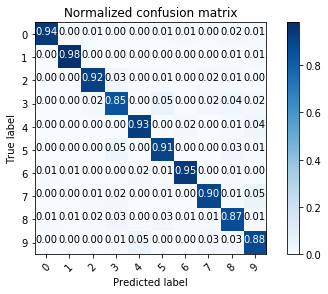

In [11]:
plot_confusion_matrix(conf, classes = [str(i) for i in range(10)], normalize=True,
                      title='Normalized confusion matrix')